### Notebook: Stacked bar chart that breaks down SVI indicators in 4 High Vulnerability (HH) census tracts (by neighborhood) ### 

After identifying spatially significant clusters of high vulnerability census tracts (HH) and overlaying these clusters with neighborhood boundaries, we were able to determine which neighborhoods have the higest vulnerability. We selected 4 high priority neighborhoods based on % area overlap with high vulnerability census tract clusters and population size. These neighborhoods also happened to be geographically distinct and spread out over LA County. 

Based on our existing knowledge of LA County, and how different geographic areas can vary significantly from each other, we felt that these priority neighborhoods merited further analysis at the census tract level

In this notebook I have created a stacked bar chart that shows individual SVI indicators for the highest SVI census tract in each of the 4 priority neighborhoods (Long Beach, Montebello, Koreatown, Lake Los Angeles). These indicators were identified as part of the 2021 LA County Climate Vulnerability Assessment and together, they determine overall SVI score. By looking at individual indicators, we can better understand how vulnerability profiles differ between neighborhoods (Long Beach, Montebello, Koreatown, Lake Los Angeles) and community types (coastal, suburban, urban, rural).

In [1]:
#import libraries
import pandas as pd
import geopandas as gpd
import fiona
import geopandas.geoseries  
import folium
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
#import SVI data
svi = gpd.read_file('data/Los_Angeles_County_CVA_Social_Vulnerability_Index.geojson')
svi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Census_Tract                     2327 non-null   object  
 1   County                           2327 non-null   object  
 2   CSA_Type                         2327 non-null   object  
 3   CSA_Label                        2327 non-null   object  
 4   DRP_Planning_Area                2327 non-null   object  
 5   DPH_Service_Planning_Area        2327 non-null   object  
 6   City_of_Los_Angeles_CPA          994 non-null    object  
 7   Population                       2327 non-null   int64   
 8   Children                         2327 non-null   float64 
 9   Older_Adults                     2327 non-null   float64 
 10  Older_Adults_Living_Alone        2327 non-null   float64 
 11  Limited_English                  2327 non-null   float64 
 12

Currently, SVI data is displayed at the census tract level and has no neighborhood data. I will need to import a file with neighborhood geographies to know which neighborhoods each census tract belongs to. 

In [3]:
#Import neighborhood shapes
nei = gpd.read_file('data/Los Angeles Neighborhood Map.geojson')
nei.head()
nei.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Conducting spatial join between SVI data at census tract level and neighborhood shapes to see which census tracts are included in neighborhood boundaries

In [4]:
#spatial join btw SVI and neighborhood data
svi_by_nei = svi.sjoin(nei, how="inner", predicate='intersects')

In [5]:
nei.head(3)

,external_i,name,location,latitude,slug_1,sqmi,display_na,set,slug,longitude,name_1,kind,type,geometry
0,acton,Acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,None,39.3391089485,Acton L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),acton,34.497355239240846,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894..."
1,adams-normandie,Adams-Normandie,POINT(34.031461499124156 -118.30020800000011),-118.30020800000011,None,0.805350187789,Adams-Normandie L.A. County Neighborhood (Curr...,L.A. County Neighborhoods (Current),adams-normandie,34.031461499124156,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.30901 34.03741, -118.3004..."
2,agoura-hills,Agoura Hills,POINT(34.146736499122795 -118.75988450000015),-118.75988450000015,None,8.14676029818,Agoura Hills L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agoura-hills,34.146736499122795,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.76193 34.16820, -118.7263..."


In [6]:
svi.head(3)

,Census_Tract,County,CSA_Type,CSA_Label,DRP_Planning_Area,DPH_Service_Planning_Area,City_of_Los_Angeles_CPA,Population,Children,Older_Adults,...,Asian,NHOPI,Other_Race,Two_or_More_Races,SoVI_Score,SoVI_Thirds,ObjectId,Shape__Area,Shape__Length,geometry
0,Census Tract 5709.02,Los Angeles County,City,City of Lakewood,Gateway Planning Area,East,None,3765,27.8,14.0,...,10.9,0.0,0.4,8.0,2.25,3,1,1.536760e+06,5208.283880,"POLYGON ((-118.12509 33.86032, -118.12287 33.8..."
1,Census Tract 5715.02,Los Angeles County,City,City of Long Beach,Gateway Planning Area,South Bay,None,4700,24.6,14.0,...,21.7,0.1,0.6,1.3,-1.77,1,2,2.001416e+06,5938.830961,"POLYGON ((-118.19274 33.84376, -118.18975 33.8..."
2,Census Tract 9106.05,Los Angeles County,City,City of Palmdale,Antelope Valley Planning Area,Antelope Valley,None,4710,38.4,7.0,...,5.3,0.0,0.2,2.5,2.39,3,3,1.996430e+06,5983.046762,"POLYGON ((-118.07616 34.57281, -118.06728 34.5..."


In [7]:
# display.max_columns option controls the number of columns to be printed
pd.set_option('display.max_columns', None)

In [8]:
#checking if join was successful
svi_by_nei.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4916 entries, 0 to 2270
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Census_Tract                     4916 non-null   object  
 1   County                           4916 non-null   object  
 2   CSA_Type                         4916 non-null   object  
 3   CSA_Label                        4916 non-null   object  
 4   DRP_Planning_Area                4916 non-null   object  
 5   DPH_Service_Planning_Area        4916 non-null   object  
 6   City_of_Los_Angeles_CPA          2026 non-null   object  
 7   Population                       4916 non-null   int64   
 8   Children                         4916 non-null   float64 
 9   Older_Adults                     4916 non-null   float64 
 10  Older_Adults_Living_Alone        4916 non-null   float64 
 11  Limited_English                  4916 non-null   float64 
 12

Now to clean up the data to get it ready to display in bar chart

In [9]:
#list of existing columns
svi_by_nei.columns.to_list()

['Census_Tract',
 'County',
 'CSA_Type',
 'CSA_Label',
 'DRP_Planning_Area',
 'DPH_Service_Planning_Area',
 'City_of_Los_Angeles_CPA',
 'Population',
 'Children',
 'Older_Adults',
 'Older_Adults_Living_Alone',
 'Limited_English',
 'No_High_School_Diploma',
 'Female',
 'Female_Householder',
 'Asthma',
 'Cardiovascular_Disease',
 'Disability',
 'No_Health_Insurance',
 'Living_in_Group_Quarters',
 'Mobile_Homes',
 'Rent_Burden',
 'Renters',
 'Median_Income',
 'Poverty',
 'Households_Without_Vehicle_Acce',
 'Transit_Access',
 'Outdoor_Workers',
 'Unemployed',
 'Foreign_Born',
 'Library_Access',
 'No_Internet_Subscription',
 'Voter_Turnout_Rate',
 'Hispanic_Latinx',
 'White',
 'Black',
 'Native_Tribal',
 'Asian',
 'NHOPI',
 'Other_Race',
 'Two_or_More_Races',
 'SoVI_Score',
 'SoVI_Thirds',
 'ObjectId',
 'Shape__Area',
 'Shape__Length',
 'geometry',
 'index_right',
 'external_i',
 'name',
 'location',
 'latitude',
 'slug_1',
 'sqmi',
 'display_na',
 'set',
 'slug',
 'longitude',
 'name_1',
 

In [10]:
#list of columns to keep
columns_to_keep = ['Census_Tract',
 'Population',
 'Children',
 'Older_Adults_Living_Alone',
 'Limited_English',
 'No_High_School_Diploma',
 'Female_Householder',
 'Asthma',
 'Cardiovascular_Disease',
 'Disability',
 'No_Health_Insurance',
 'Living_in_Group_Quarters',
 'Mobile_Homes',
 'Rent_Burden',
 'Renters',
 'Poverty',
 'Households_Without_Vehicle_Acce',
 'Transit_Access',
 'Outdoor_Workers',
 'Unemployed',
 'Foreign_Born',
 'Library_Access',
 'No_Internet_Subscription',
 'Hispanic_Latinx',
 'White',
 'Black',
 'Native_Tribal',
 'Asian',
 'NHOPI',
 'Other_Race',
 'SoVI_Score',
 'geometry',
 'name',
 'location',
 'type']

# add it to a new dataframe
svi_by_nei = svi_by_nei[columns_to_keep]

svi_by_nei.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4916 entries, 0 to 2270
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Census_Tract                     4916 non-null   object  
 1   Population                       4916 non-null   int64   
 2   Children                         4916 non-null   float64 
 3   Older_Adults_Living_Alone        4916 non-null   float64 
 4   Limited_English                  4916 non-null   float64 
 5   No_High_School_Diploma           4916 non-null   float64 
 6   Female_Householder               4916 non-null   float64 
 7   Asthma                           4916 non-null   float64 
 8   Cardiovascular_Disease           4916 non-null   float64 
 9   Disability                       4916 non-null   float64 
 10  No_Health_Insurance              4916 non-null   float64 
 11  Living_in_Group_Quarters         4916 non-null   float64 
 12

Now that I have all of the relevant columns I need, I want to query the data for just the census tracts I'm interested in (aka the census tracts with the highest SVI score in each of the 4 priority neighborhoods identified earlier through spatial autocorrelation).

In [11]:
#create dataframe for only the census tracts for the neighborhoods that are HH clusters
montebello = svi_by_nei[svi_by_nei['name']=='Montebello']
montebello_sorted = montebello.sort_values(by='SoVI_Score',ascending = False)

#top10
montebello_top = montebello_sorted.head(1)
montebello_top

,Census_Tract,Population,Children,Older_Adults_Living_Alone,Limited_English,No_High_School_Diploma,Female_Householder,Asthma,Cardiovascular_Disease,Disability,No_Health_Insurance,Living_in_Group_Quarters,Mobile_Homes,Rent_Burden,Renters,Poverty,Households_Without_Vehicle_Acce,Transit_Access,Outdoor_Workers,Unemployed,Foreign_Born,Library_Access,No_Internet_Subscription,Hispanic_Latinx,White,Black,Native_Tribal,Asian,NHOPI,Other_Race,SoVI_Score,geometry,name,location,type
989,Census Tract 5320.01,2822,26.8,20.4,36.0,44.2,14.6,41.4,8.3,18.1,14.5,0.0,0.0,71.1,72.1,23.5,14.6,100.0,8.8,3.2,40.2,2.0,46.5,93.5,4.5,1.3,0.0,0.7,0.0,0.0,4.98,"POLYGON ((-118.12982 34.00242, -118.12708 34.0...",Montebello,POINT(34.010314998189017 -118.10833743364199),standalone-city


In [12]:
#create dataframe for only the census tracts for the neighborhoods that are HH clusters
lakelosangeles = svi_by_nei[svi_by_nei['name']=='Lake Los Angeles']
lakelosangeles_sorted = lakelosangeles.sort_values(by='SoVI_Score',ascending = False)

#top10
lakelosangeles_top = lakelosangeles_sorted.head(1)
lakelosangeles_top

,Census_Tract,Population,Children,Older_Adults_Living_Alone,Limited_English,No_High_School_Diploma,Female_Householder,Asthma,Cardiovascular_Disease,Disability,No_Health_Insurance,Living_in_Group_Quarters,Mobile_Homes,Rent_Burden,Renters,Poverty,Households_Without_Vehicle_Acce,Transit_Access,Outdoor_Workers,Unemployed,Foreign_Born,Library_Access,No_Internet_Subscription,Hispanic_Latinx,White,Black,Native_Tribal,Asian,NHOPI,Other_Race,SoVI_Score,geometry,name,location,type
915,Census Tract 9001.02,588,19.3,28.5,12.1,43.1,6.6,108.4,13.5,21.1,9.9,0.0,19.1,55.3,36.7,32.9,16.8,0.0,18.5,5.2,24.0,7.3,44.5,48.0,44.7,1.5,0.0,2.2,0.0,0.7,4.13,"POLYGON ((-117.77437 34.82330, -117.77421 34.8...",Lake Los Angeles,POINT(34.611038948416571 -117.83603921804665),unincorporated-area


In [13]:
#create dataframe for only the census tracts for the neighborhoods that are HH clusters
longbeach = svi_by_nei[svi_by_nei['name']=='Long Beach']
longbeach_sorted = longbeach.sort_values(by='SoVI_Score',ascending = False)

#top10
longbeach_top = longbeach_sorted.head(1)
longbeach_top

,Census_Tract,Population,Children,Older_Adults_Living_Alone,Limited_English,No_High_School_Diploma,Female_Householder,Asthma,Cardiovascular_Disease,Disability,No_Health_Insurance,Living_in_Group_Quarters,Mobile_Homes,Rent_Burden,Renters,Poverty,Households_Without_Vehicle_Acce,Transit_Access,Outdoor_Workers,Unemployed,Foreign_Born,Library_Access,No_Internet_Subscription,Hispanic_Latinx,White,Black,Native_Tribal,Asian,NHOPI,Other_Race,SoVI_Score,geometry,name,location,type
1753,Census Tract 5758.03,2938,26.7,30.3,23.8,35.5,8.0,115.3,11.3,15.6,14.9,0.6,0.0,57.1,88.7,36.4,36.9,100.0,7.1,6.6,39.1,0.8,35.9,61.3,17.1,11.2,0.4,8.2,0.0,0.0,7.25,"POLYGON ((-118.19506 33.78259, -118.19372 33.7...",Long Beach,POINT(33.806580699978731 -118.156064),standalone-city


In [21]:
#create dataframe for only the census tracts for the neighborhoods that are HH clusters
ktown = svi_by_nei[svi_by_nei['name']=='Koreatown']
ktown_sorted = ktown.sort_values(by='SoVI_Score',ascending = False)

#top10
ktown_top = ktown_sorted.head(1)
ktown_top

,Census_Tract,Population,Children,Older_Adults_Living_Alone,Limited_English,No_High_School_Diploma,Female_Householder,Asthma,Cardiovascular_Disease,Disability,No_Health_Insurance,Living_in_Group_Quarters,Mobile_Homes,Rent_Burden,Renters,Poverty,Households_Without_Vehicle_Acce,Transit_Access,Outdoor_Workers,Unemployed,Foreign_Born,Library_Access,No_Internet_Subscription,Hispanic_Latinx,White,Black,Native_Tribal,Asian,NHOPI,Other_Race,SoVI_Score,geometry,name,location,type
2287,Census Tract 2122.03,2978,19.8,21.2,57.0,57.3,15.8,38.6,7.0,10.1,32.6,0.0,1.3,59.5,100.0,50.1,46.4,100.0,19.5,6.9,71.7,0.4,47.2,62.7,5.4,4.1,0.0,24.8,0.8,0.6,5.35,"POLYGON ((-118.29164 34.06179, -118.28909 34.0...",Koreatown,POINT(34.064510499123763 -118.3049585),segment-of-a-city


Now that I have identified the highest vulnerability census tracts for each of the 4 priority neighborhoods, I will create a new dataframe for just this data.

In [22]:
#create new dataframe where data is trimmed to just include featured HH neighborhoods
featured = svi_by_nei[((svi_by_nei.Census_Tract=='Census Tract 5320.01') & (svi_by_nei.name=='Montebello')) | ((svi_by_nei.Census_Tract=='Census Tract 9001.02') & (svi_by_nei.name == 'Lake Los Angeles')) | ((svi_by_nei.Census_Tract=='Census Tract 5758.03')& (svi_by_nei.name == 'Long Beach')) | ((svi_by_nei.Census_Tract=='Census Tract 2122.03') & (svi_by_nei.name=='Koreatown')) ]
featured.head(10)

,Census_Tract,Population,Children,Older_Adults_Living_Alone,Limited_English,No_High_School_Diploma,Female_Householder,Asthma,Cardiovascular_Disease,Disability,No_Health_Insurance,Living_in_Group_Quarters,Mobile_Homes,Rent_Burden,Renters,Poverty,Households_Without_Vehicle_Acce,Transit_Access,Outdoor_Workers,Unemployed,Foreign_Born,Library_Access,No_Internet_Subscription,Hispanic_Latinx,White,Black,Native_Tribal,Asian,NHOPI,Other_Race,SoVI_Score,geometry,name,location,type
1753,Census Tract 5758.03,2938,26.7,30.3,23.8,35.5,8.0,115.3,11.3,15.6,14.9,0.6,0.0,57.1,88.7,36.4,36.9,100.0,7.1,6.6,39.1,0.8,35.9,61.3,17.1,11.2,0.4,8.2,0.0,0.0,7.25,"POLYGON ((-118.19506 33.78259, -118.19372 33.7...",Long Beach,POINT(33.806580699978731 -118.156064),standalone-city
989,Census Tract 5320.01,2822,26.8,20.4,36.0,44.2,14.6,41.4,8.3,18.1,14.5,0.0,0.0,71.1,72.1,23.5,14.6,100.0,8.8,3.2,40.2,2.0,46.5,93.5,4.5,1.3,0.0,0.7,0.0,0.0,4.98,"POLYGON ((-118.12982 34.00242, -118.12708 34.0...",Montebello,POINT(34.010314998189017 -118.10833743364199),standalone-city
2287,Census Tract 2122.03,2978,19.8,21.2,57.0,57.3,15.8,38.6,7.0,10.1,32.6,0.0,1.3,59.5,100.0,50.1,46.4,100.0,19.5,6.9,71.7,0.4,47.2,62.7,5.4,4.1,0.0,24.8,0.8,0.6,5.35,"POLYGON ((-118.29164 34.06179, -118.28909 34.0...",Koreatown,POINT(34.064510499123763 -118.3049585),segment-of-a-city
915,Census Tract 9001.02,588,19.3,28.5,12.1,43.1,6.6,108.4,13.5,21.1,9.9,0.0,19.1,55.3,36.7,32.9,16.8,0.0,18.5,5.2,24.0,7.3,44.5,48.0,44.7,1.5,0.0,2.2,0.0,0.7,4.13,"POLYGON ((-117.77437 34.82330, -117.77421 34.8...",Lake Los Angeles,POINT(34.611038948416571 -117.83603921804665),unincorporated-area


In order to create a stacked bar chart for the type of data I have, I need to convert all datatypes from floats to integers for it to display correctly. I had to exclude asthma, cardiovascular disease, median income, and library access as those data fields had different measurement metrics (eg case rates per 100,000) and could not be displayed accurately in the stacked bar chart format.

In [15]:
#create list of only SVI indicators to convert to int 
svi_indicators=['Children',
 'Older_Adults_Living_Alone',
 'Limited_English',
 'No_High_School_Diploma',
 'Female_Householder',
 'Disability',
 'No_Health_Insurance',
 'Living_in_Group_Quarters',
 'Mobile_Homes',
 'Rent_Burden',
 'Renters',
 'Poverty',
 'Households_Without_Vehicle_Acce',
 'Transit_Access',
 'Outdoor_Workers',
 'Unemployed',
 'Foreign_Born',
 'No_Internet_Subscription',
 'Hispanic_Latinx',
 'White',
 'Black',
 'Native_Tribal',
 'Asian',
 'NHOPI',
 'Other_Race']

In [16]:
#convert columns to int
for i in svi_indicators:
    featured = featured.astype({i:'int'})
    
featured.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3 entries, 1753 to 915
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Census_Tract                     3 non-null      object  
 1   Population                       3 non-null      int64   
 2   Children                         3 non-null      int64   
 3   Older_Adults_Living_Alone        3 non-null      int64   
 4   Limited_English                  3 non-null      int64   
 5   No_High_School_Diploma           3 non-null      int64   
 6   Female_Householder               3 non-null      int64   
 7   Asthma                           3 non-null      float64 
 8   Cardiovascular_Disease           3 non-null      float64 
 9   Disability                       3 non-null      int64   
 10  No_Health_Insurance              3 non-null      int64   
 11  Living_in_Group_Quarters         3 non-null      int64   
 12 

Now it's time to display the data as a stacked bar chart!

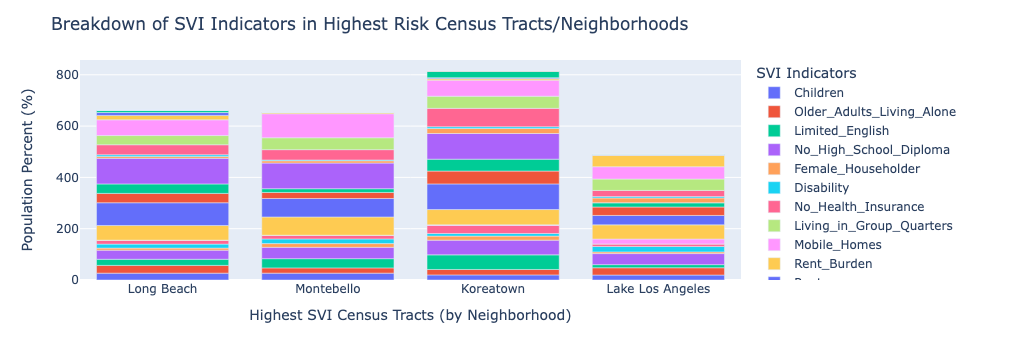

In [38]:
# make a stacked bar chart
fig = px.bar(featured,
       x='name',
       y=svi_indicators,
      #color='grp_description', # this creates the "stack"
        labels={'Social Vulnerability Indicators'})

fig.update_traces(textposition='outside')
#adding titles
fig.update_layout(
    title='Breakdown of SVI Indicators in Highest Risk Census Tracts/Neighborhoods',
    yaxis=dict(title='Population Percent (%)'),
    xaxis=dict(title='Highest SVI Census Tracts (by Neighborhood)'),
    legend=dict(title='SVI Indicators')

)

fig.show()

In [39]:
fig.write_html("SVI_stackedbar.html")

Quantitative analysis of this stacked bar chart was completed as part of our project and results are displayed in the Storymap portion of our project.